# Assignment 1: Neural Networks

Implement your code and answer all the questions. Once you complete the assignment and answer the questions inline, you can download the report in pdf (File->Download as->PDF) and send it to us, together with the code. 

**Don't submit additional cells in the notebook, we will not check them. Don't change parameters of the learning inside the cells.**

Assignment 1 consists of 4 sections:
* **Section 1**: Data Preparation
* **Section 2**: Multinomial Logistic Regression
* **Section 3**: Backpropagation
* **Section 4**: Neural Networks


In [1]:
# Import necessary standard python packages 
import numpy as np
import matplotlib.pyplot as plt

# Setting configuration for matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20


In [2]:
# Import python modules for this assignment

from uva_code.cifar10_utils import get_cifar10_raw_data, preprocess_cifar10_data
from uva_code.solver import Solver
from uva_code.losses import SoftMaxLoss, CrossEntropyLoss, HingeLoss
from uva_code.layers import LinearLayer, ReLULayer, SigmoidLayer, TanhLayer, SoftMaxLayer, ELULayer
from uva_code.models import Network
from uva_code.optimizers import SGD

%load_ext autoreload
%autoreload 2

## Section 1:  Data Preparation

In this section you will download [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html "CIFAR10") data which you will use in this assignment. 

**Make sure that everything has been downloaded correctly and all images are visible.**

In [3]:
# Get raw CIFAR10 data. For Unix users the script to download CIFAR10 dataset (get_cifar10.sh) is provided and 
# it is used inside get_cifar10_raw_data() function. If it doesn't work then manually download the data from 
# http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract it to cifar-10-batches-py folder inside 
# cifar10 folder.

# Downloading the data can take several minutes.  
X_train_raw, Y_train_raw, X_test_raw, Y_test_raw = get_cifar10_raw_data()

#Checking shapes, should be (50000, 32, 32, 3), (50000, ), (10000, 32, 32, 3), (10000, )
print 'Train data shape: ', X_train_raw.shape
print 'Train labels shape: ', Y_train_raw.shape
print 'Test data shape: ', X_test_raw.shape
print 'Test labels shape: ', Y_test_raw.shape

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


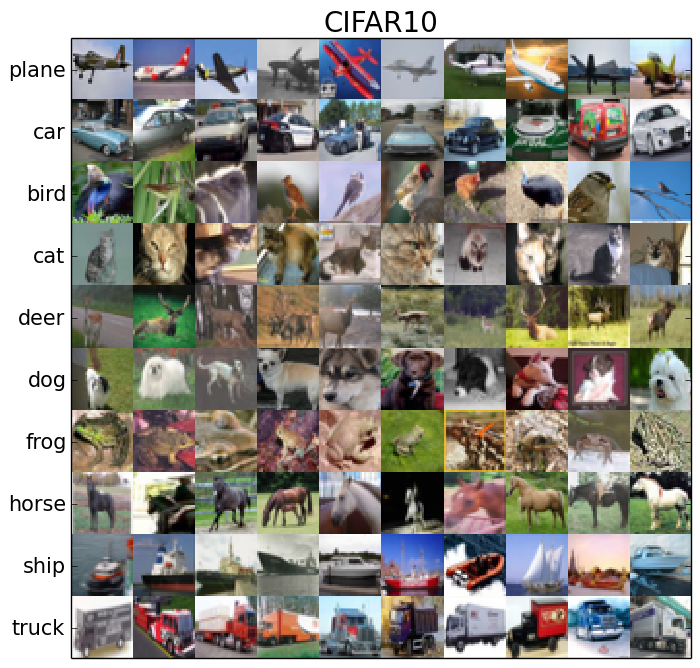

In [4]:
# Visualize CIFAR10 data
samples_per_class = 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = len(classes)
can = np.zeros((320, 320, 3),dtype='uint8')
for i, cls in enumerate(classes):
    idxs = np.flatnonzero(Y_train_raw == i) 
    idxs = np.random.choice(idxs, samples_per_class, replace = False)
    for j in range(samples_per_class):
        can[32 * i:32 * (i + 1), 32 * j:32 * (j + 1),:] = X_train_raw[idxs[j]]
plt.xticks([], [])
plt.yticks(range(16, 320, 32), classes)
plt.title('CIFAR10', fontsize = 20)
plt.imshow(can)
plt.show()

In [5]:
# Normalize CIFAR10 data by subtracting the mean image. With these data you will work in the rest of assignment.
# The validation subset will be used for tuning the hyperparameters.
X_train, Y_train, X_val, Y_val, X_test, Y_test = preprocess_cifar10_data(X_train_raw, Y_train_raw, 
                                                                         X_test_raw, Y_test_raw, num_val = 1000)

#Checking shapes, should be (49000, 3072), (49000, ), (1000, 3072), (1000, ), (10000, 3072), (10000, ) 
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', Y_train.shape
print 'Val data shape: ', X_val.shape
print 'Val labels shape: ', Y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', Y_test.shape

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Val data shape:  (1000, 3072)
Val labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


### Data Preparation: Question 1 [4 points]

Neural networks and deep learning methods prefer the input variables to contain as raw data as possible. 
But in the vast majority of cases data need to be preprocessed. Suppose, you have two types of non-linear  activation functions ([Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and two types of normalization ([Per-example mean substraction](http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing#Per-example_mean_subtraction), [Standardization](http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing#Feature_Standardization)). Which one should you use for each case and why? For example, in the previous cell we used per-example mean substraction.

**Your Answer**: ReLU activation is more computationally efficient than sigmiod activation, and does not suffer from the vanishing gradient problem. It is particularly efficient when working with large input data or many hidden units, due to the ReLU function allowing sparse activation. The internet is surprisingly silent on the benefits of sigmoid functions over ReLU, but it can at least be said that sigmoid functions normalize the output, and hence can be used to represent probabilities. Per-example mean subtraction can be used when we can make the assumption that all variables in a dataset are similarly distributed, feature standardization is usual in other cases.

## Section 2: Multinomial Logistic Regression [5 points]

In this section you will get started by implementing a linear classification model called [Multinomial Logistic Regression](http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/). Later on you will extend this model to a neural network. You will train it by using the [mini-batch Stochastic Gradient Descent algorithm](http://sebastianruder.com/optimizing-gradient-descent/index.html#minibatchgradientdescent). You should implement how to sample batches, how to compute the loss, how to compute the gradient of the loss with respect to the parameters of the model and how to update the parameters of the model. 

You should get around 0.35 accuracy on the validation and test sets with the provided parameters.


In [6]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
learning_rate = 1e-7
weight_decay = 3e+4
weight_scale = 0.0001

#no magic numbers pls:
x_size = 3072
numclasses = 10
total_train = 49000

valid_size = 1000
test_size = 10000

########################################################################################
# TODO:                                                                                #
# Initialize the weights W using a normal distribution with mean = 0 and std =         #
# weight_scale. Initialize the biases b with 0.                                        #
########################################################################################   
W = np.zeros((numclasses, x_size))

for i in range(numclasses):
    for j in range(x_size):
        W[i,j] = np.random.normal(0, weight_scale)

b = np.zeros(numclasses)
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################

train_loss_history = []
train_acc_history = []

val_loss_history = []
val_acc_history = []

for iteration in range(num_iterations):
    ########################################################################################
    # TODO:                                                                                #
    # Sample a random mini-batch with the size of batch_size from the train set. Put the   #
    # images to X_train_batch and labels to Y_train_batch variables.                       #
    ########################################################################################
    
    indices = np.random.choice(range(total_train), batch_size, replace=False)
    
    X_train_batch = X_train[indices]
    Y_train_batch = Y_train[indices]
    
    ########################################################################################
    #                              END OF YOUR CODE                                        #
    ########################################################################################
    
    ########################################################################################
    # TODO:                                                                                #
    # Compute the loss and the accuracy of the multinomial logistic regression classifier  #
    # on X_train_batch, Y_train_batch.                                                     #
    ########################################################################################
    
    train_loss = 0
    train_acc = 0
    logp = np.zeros([batch_size,numclasses]) #will contain the computed likelihoods
    p_t = np.zeros([batch_size, numclasses]) #the true values
    for i in range(batch_size):
        row = X_train_batch[i,:]
        logq = (W.dot(row) + b)
        a = max(logq)
        logz = 0
        for q in logq:
            logz += np.exp(q - a)
        logz = a + np.log(logz)
        logp[i,:] = logq - logz
        p_t[i,:] = np.zeros(10)
        p_t[i, Y_train_batch[i]] = 1
        
        train_acc += np.argmax(logp[i,:]) == Y_train_batch[i]
            
    train_loss = (-(p_t * logp).sum())/batch_size + weight_decay * 0.5 * (W**2).sum()
        
    
    
    train_acc = float(train_acc) / float(batch_size)
        


    ########################################################################################
    #                              END OF YOUR CODE                                        #
    ########################################################################################
    
    ########################################################################################
    # TODO:                                                                                #
    # Compute the gradients of the loss with the respect to the weights and biases. Put    #
    # them in dW and db variables.                                                         #
    ########################################################################################
    
    #initialise
    
    
    db =0
    dW = 0
    
    # add gradient for every example
    for i in range(batch_size):
        dbi = (p_t[i,:] - np.exp(logp[i,:]))/batch_size
        db += dbi
        dW += np.outer(dbi,X_train_batch[i,:]) 
        
    dW -= weight_decay * W
    
    
    
    
    
    
    
    
    
    ########################################################################################
    #                              END OF YOUR CODE                                        #
    ########################################################################################
    
    
    
    
    ########################################################################################
    # TODO:                                                                                #
    # Update the weights W and biases b using the Stochastic Gradient Descent update rule. #
    ########################################################################################

    
    W += learning_rate * dW
    b += learning_rate * db
    
    ########################################################################################
    #                              END OF YOUR CODE                                        #
    ########################################################################################
    
    if iteration % val_iteration == 0 or iteration == num_iterations - 1:
        ########################################################################################
        # TODO:                                                                                #
        # Compute the loss and the accuracy on the validation set.                             #
        ########################################################################################
        val_loss = 0
        val_acc = 0
        vlogp = np.zeros([valid_size,numclasses]) #will contain the computed likelihoods
        vp_t = np.zeros([valid_size, numclasses]) #the true values
        for i in range(valid_size):
            row = X_val[i,:]
            vlogq = (W.dot(row) + b)
            a = max(vlogq)
            vlogz = 0
            for q in vlogq:
                vlogz += np.exp(q - a)
            vlogz = a + np.log(vlogz)
            vlogp[i,:] = vlogq - vlogz
            vp_t[i,:] = np.zeros(10)
            vp_t[i, Y_val[i]] = 1
        
            val_acc += np.argmax(vlogp[i,:]) == Y_val[i]
            
        val_loss = (-(vp_t * vlogp).sum())/valid_size + weight_decay * 0.5 * (W**2).sum()
        
        

        val_acc = float(val_acc) / float(valid_size)

        ########################################################################################
        #                              END OF YOUR CODE                                        #
        ########################################################################################
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        # Output loss and accuracy during training
        print("Iteration {0:d}/{1:d}. Train Loss = {2:.3f}, Train Accuracy = {3:.3f}".
              format(iteration, num_iterations, train_loss, train_acc))
        print("Iteration {0:d}/{1:d}. Validation Loss = {2:.3f}, Validation Accuracy = {3:.3f}".
              format(iteration, num_iterations, val_loss, val_acc))



            
########################################################################################
# TODO:                                                                                #
# Compute the accuracy on the test set.                                                #
########################################################################################

test_acc = 0
tlogp = np.zeros([test_size,numclasses]) #will contain the computed likelihoods

for i in range(test_size):
    row = X_test[i,:]
    tlogq = (W.dot(row) + b)
    a = max(tlogq)
    tlogz = 0
    for q in tlogq:
        tlogz += np.exp(q - a)
    tlogz = a + np.log(tlogz)
    tlogp[i,:] = tlogq - tlogz
    
    test_acc += np.argmax(tlogp[i,:]) == Y_test[i]
    
  
        
        

test_acc = float(test_acc) / float(test_size)
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
print("Test Accuracy = {0:.3f}".format(test_acc))

Iteration 0/1500. Train Loss = 6.910, Train Accuracy = 0.130
Iteration 0/1500. Validation Loss = 6.896, Validation Accuracy = 0.125
Iteration 100/1500. Train Loss = 4.608, Train Accuracy = 0.245
Iteration 100/1500. Validation Loss = 4.596, Validation Accuracy = 0.289
Iteration 200/1500. Train Loss = 3.486, Train Accuracy = 0.285
Iteration 200/1500. Validation Loss = 3.430, Validation Accuracy = 0.334
Iteration 300/1500. Train Loss = 2.821, Train Accuracy = 0.330
Iteration 300/1500. Validation Loss = 2.801, Validation Accuracy = 0.350
Iteration 400/1500. Train Loss = 2.425, Train Accuracy = 0.295
Iteration 400/1500. Validation Loss = 2.459, Validation Accuracy = 0.352
Iteration 500/1500. Train Loss = 2.308, Train Accuracy = 0.365
Iteration 500/1500. Validation Loss = 2.272, Validation Accuracy = 0.356
Iteration 600/1500. Train Loss = 2.162, Train Accuracy = 0.325
Iteration 600/1500. Validation Loss = 2.169, Validation Accuracy = 0.358
Iteration 700/1500. Train Loss = 2.106, Train Accura

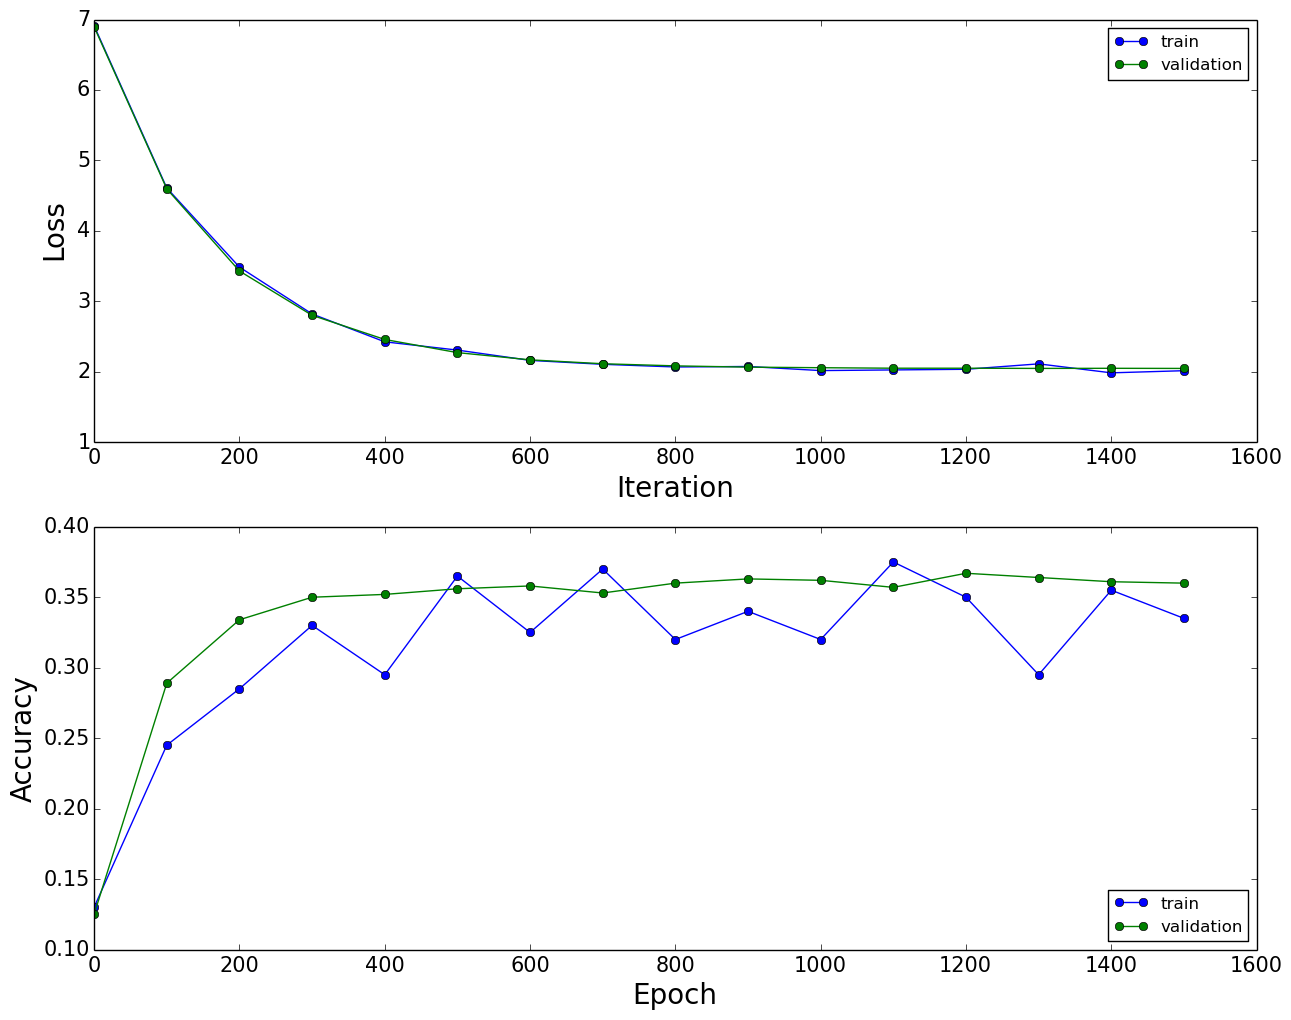

In [7]:
# Visualize a learning curve of multinomial logistic regression classifier
plt.subplot(2, 1, 1)
plt.plot(range(0, num_iterations + 1, val_iteration), train_loss_history, '-o', label = 'train')
plt.plot(range(0, num_iterations + 1, val_iteration), val_loss_history, '-o', label = 'validation')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.plot(range(0, num_iterations + 1, val_iteration), train_acc_history, '-o', label='train')
plt.plot(range(0, num_iterations + 1, val_iteration), val_acc_history, '-o', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

### Multinomial Logistic Regression: Question 1 [4 points]

What is the value of the loss and the accuracy you expect to obtain at iteration = 0 and why? Consider weight_decay = 0.

**Your Answer**: As the initial parameters are randomized, you would expect around 0.1 accuracy, which is the accuracy of complete random guessing. The loss function is cross entropy with a regularization term, hence the loss we would expect is the cross entropy of two unrelated datasets, plus the regularization.   The case with weight_decay = 0 is unregularized multinomial logistic regression, which is prone to overfitting.

### Multinomial Logistic Regression: Question 2 [4 points]

Name at least three factors that determine the size of batches in practice and briefly motivate your answers. The factors might be related to computational or performance aspects.

**Your Answer**: 

### Mulinomial Logistic Regression: Question 3 [4 points]

Does the learning rate depend on the batch size? Explain how you should change the learning rate with respect to changes of the batch size.

Name two extreme choices of a batch size and explain their advantages and disadvantages.

**Your Answer**: In my implementation the gradients were averaged over the elements in the batch, which naturally scales the learning rate to decrease with batch size. Since a larger batch size means a larger confidence in the resulting gradient, this does not always have to be the case.

### Multinomial Logistic Regression: Question 4 [4 points]

How can you describe the rows of weight matrix W? What are they representing? Why? 

**Your Answer**: Every row of W maps an input variable to a class. In the case of CIFAR10, it maps each color value for each pixel to a class. Each weight within a row represents the contribution of that pixel to the likelihood of the corresponding class.

**Hint**: Before answering the question visualize rows of weight matrix W in the cell below.

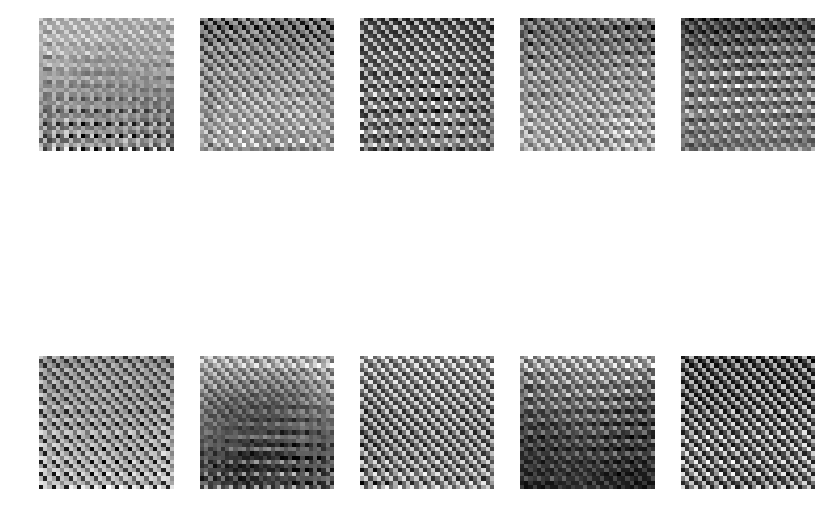

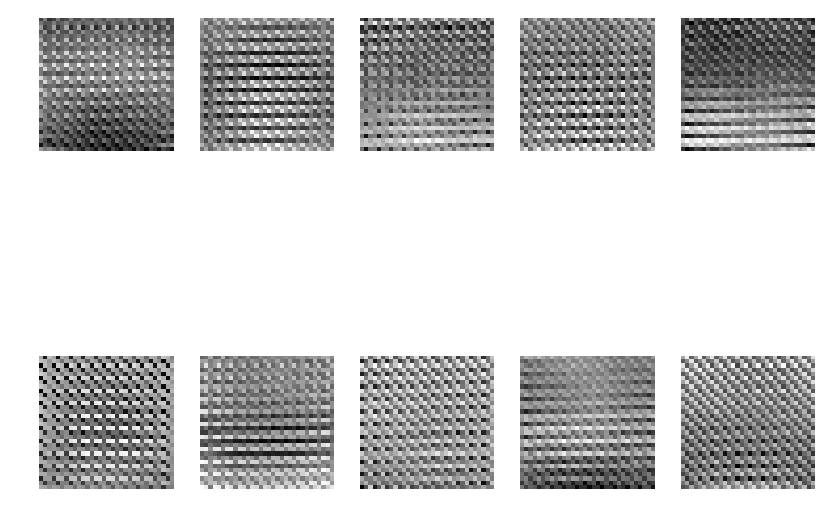

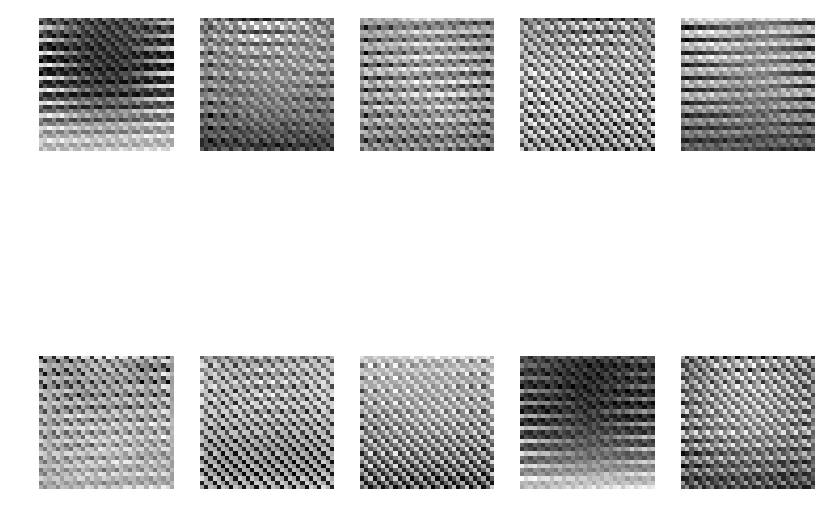

In [8]:
########################################################################################
# TODO:                                                                                #
# Visualize the learned weights for each class.                                        #
########################################################################################

#writing a function that takes a matrix of RGB values and rehsapes and visualizes it.

def visualize(W, numcols = 5, imgshape=(32,32,3)):
    numimages = W.shape[0]
    numrows = int(numimages/numcols)
    for i in range(numimages):
        plt.subplot(numrows, numcols, i)
        plt.imshow(W[i,:].reshape(imgshape))
        plt.axis("off")
    plt.show()

   

visualize(W[:,0:1024], imgshape=(32,32))
visualize(W[:,1024:2048], imgshape=(32,32))
visualize(W[:,2048:3072], imgshape=(32,32))

########################################################################################
#                              END OF YOUR CODE                                        #
#######################################################################################

## Section 3: Backpropagation

Follow the instructions and solve the tasks in paper_assignment_1.pdf. Write your solutions in a separate pdf file. You don't need to put anything here.
    

## Section 4: Neural Networks [10 points]

A modular implementation of neural networks allows to define deeper and more flexible architectures. In this section you will implement the multinomial logistic regression classifier from the Section 2 as a one-layer neural network that consists of two parts: a linear transformation layer (module 1) and a softmax loss layer (module 2).

You will implement the multinomial logistic regression classifier as a modular network by following next steps:

1. Implement the forward and backward passes for the linear layer in **layers.py** file. Write your code inside the ***forward*** and ***backward*** methods of ***LinearLayer*** class. Compute the regularization loss of the weights inside the ***layer_loss*** method of ***LinearLayer*** class. 
2. Implement the softmax loss computation in **losses.py** file. Write your code inside the ***SoftMaxLoss*** function. 
3. Implement the ***forward***, ***backward*** and ***loss*** methods for the ***Network*** class inside the **models.py** file.
4. Implement the SGD update rule inside ***SGD*** class in **optimizers.py** file.
5. Implement the ***train_on_batch***, ***test_on_batch***, ***fit***, ***predcit***, ***score***, ***accuracy*** methods of ***Solver*** class in ***solver.py*** file.

You should get the same results for the next cell as in Section 2. **Don't change the parameters**.


In [40]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
learning_rate = 1e-7
weight_decay = 3e+4
weight_scale = 0.0001

#no magic numbers pls:
x_size = 3072
numclasses = 10
total_train = 49000

valid_size = 1000
test_size = 10000


########################################################################################
# TODO:                                                                                #
# Build the multinomial logistic regression classifier using the Network model. You    #
# will need to use add_layer and add_loss methods. Train this model using Solver class #
# with SGD optimizer. In configuration of the optimizer you need to specify only       #
# learning rate. Use the fit method to train classifier. Don't forget to include       #
# X_val and Y_val in arguments to output the validation loss and accuracy during       #
# training. Set the verbose to True to compare with the  multinomial logistic          #
# regression classifier from the Section 2.                                            #
########################################################################################
model = Network()
optimizer = SGD()
optimizer_config = {"learning_rate": learning_rate}

model.add_loss(SoftMaxLoss)
model.add_layer(LinearLayer({"input_size":x_size, "output_size":numclasses, 
                             "weight_decay": weight_decay, "weight_scale":weight_scale}))


solver = Solver(model)





solver.fit(X_train, Y_train, optimizer, optimizer_config=optimizer_config,
           x_val=X_val, y_val=Y_val, batch_size=batch_size, num_iterations=num_iterations, 
           val_iteration = val_iteration, verbose = True)

########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################

########################################################################################
# TODO:                                                                                #
# Compute the accuracy on the test set.                                                #
########################################################################################
test_out, loss = solver.test_on_batch(X_test, Y_test)
test_acc = solver.accuracy(test_out, Y_test)
##########################################
##############################################
#                              END OF YOUR CODE                                        #
########################################################################################
print("Test Accuracy = {0:.3f}".format(test_acc))


(49000, 3072)
(49000,)
(200, 3072)
(200,)


ValueError: operands could not be broadcast together with shapes (200,) (10,) (200,) 

### Neural Networks: Task 1 [5 points]

Tuning hyperparameters is very important even for multinomial logistic regression. 

What are the best learning rate and weight decay? What is test accuracy of the model trained with the best hyperparameters values?

**Your Answer**: Put your answer here.

***Hint:*** You should be able to get the test accuracy around 0.4.

Implement the tuning of hyperparameters (learning rate and weight decay) in the next cell. 

In [10]:
"""
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
weight_scale = 0.0001

# You should try diffierent range of hyperparameters. 
learning_rates = [3e-4, 1e-5, 1e-6,1e-7, 1e-8, 1e-9]
weight_decays = [3e+3, 3e+04,3e+5]

best_val_acc = -1
best_solver = None
for learning_rate in learning_rates:
    for weight_decay in weight_decays:
        ########################################################################################
        # TODO:                                                                                #
        # Implement the tuning of hyperparameters for the multinomial logistic regression. Save#
        # maximum of the validation accuracy in best_val_acc and corresponding solver to       #
        # best_solver variables. Store the maximum of the validation score for the current     #
        # setting of the hyperparameters in cur_val_acc variable.                              #
        ########################################################################################
        model = Network()
        
        optimizer = SGD()
        optimizer_config = {"learning_rate": learning_rate}

        model.add_loss(SoftMaxLoss)
        model.add_layer(LinearLayer({"input_size":x_size, "output_size":numclasses, 
                             "weight_decay": weight_decay, "weight_scale":weight_scale}))


        solver = Solver(model)





        solver.fit(X_train, Y_train, optimizer, optimizer_config=optimizer_config,
                   x_val=None, y_val=None, batch_size=batch_size, num_iterations=num_iterations, 
                   val_iteration = 100, verbose = True)
        
        val_out, val_loss = solver.test_on_batch(X_val, Y_val)
        cur_val_acc = solver.accuracy(test_out, Y_test)
        print cur_val_acc
        print val_loss
        if cur_val_acc > best_val_acc:
                print "new best"
                best_val_acc = cur_val_acc
                best_solver = solver
        ########################################################################################
        #                              END OF YOUR CODE                                        #
        ########################################################################################
        print("Learning rate = {0:e}, weight decay = {1:e}: Validation Accuracy = {2:.3f}".format(
            learning_rate, weight_decay, cur_val_acc))    

########################################################################################
# TODO:                                                                                #
# Compute the accuracy on the test set for the best solver.                          #
########################################################################################
test_out, loss = best_solver.test_on_batch(X_test, Y_test)
test_acc = best_solver.accuracy(test_out, Y_test)
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
print("Best Test Accuracy = {0:.3f}".format(test_acc))
"""

'\n# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!\n# Seed\nnp.random.seed(42)\n\n# Default parameters. \nnum_iterations = 1500\nval_iteration = 100\nbatch_size = 200\nweight_scale = 0.0001\n\n# You should try diffierent range of hyperparameters. \nlearning_rates = [3e-4, 1e-5, 1e-6,1e-7, 1e-8, 1e-9]\nweight_decays = [3e+3, 3e+04,3e+5]\n\nbest_val_acc = -1\nbest_solver = None\nfor learning_rate in learning_rates:\n    for weight_decay in weight_decays:\n        ########################################################################################\n        # TODO:                                                                                #\n        # Implement the tuning of hyperparameters for the multinomial logistic regression. Save#\n        # maximum of the validation accuracy in best_val_acc and corresponding solver to       #\n        # best_solver variables. Store the maximum of the validation score for the curren

### Neural Networks: Task 2 [5 points]

Implement a two-layer neural network with a ReLU activation function. Write your code for the ***forward*** and ***backward*** methods of ***ReLULayer*** class in **layers.py** file.

Train the network with the following structure: linear_layer-relu-linear_layer-softmax_loss. You should get the accuracy on the test set around 0.44. 

In [14]:
#Testing
relayer = ReLULayer()
relayer.train_mode = True
print relayer.forward(np.array([[1, 2],[-3, 4]]))
print relayer.backward(np.array([[4, 2],[-1, -4]]))

[[1 2]
 [0 4]]
[[ 4  2]
 [ 0 -4]]


In [39]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Number of hidden units in a hidden layer.
num_hidden_units = 100

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
learning_rate = 2e-3
weight_decay = 0
weight_scale = 0.0001

########################################################################################
# TODO:                                                                                #
# Build the model with the structure: linear_layer-relu-linear_layer-softmax_loss.     #
# Train this model using Solver class with SGD optimizer. In configuration of the      #
# optimizer you need to specify only the learning rate. Use the fit method to train.   # 
########################################################################################
model = Network()

model.add_layer(LinearLayer({"input_size":num_hidden_units, "output_size": numclasses, 
                             "weight_decay":weight_decay, "weight_scale":weight_scale}))
model.add_layer(ReLULayer())

model.add_layer(LinearLayer({"input_size":x_size, "output_size":num_hidden_units, 
                             "weight_decay":weight_decay, "weight_scale":weight_scale}))



model.add_loss(SoftMaxLoss)

optimizer = SGD()
optimizer_config = {"learning_rate":learning_rate}
solver = Solver(model)

solver.fit(X_train, Y_train, optimizer, optimizer_config=optimizer_config,
           x_val=X_val, y_val=Y_val, batch_size=batch_size, num_iterations=num_iterations, 
           val_iteration = val_iteration, verbose = True)

########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
    
########################################################################################
# TODO:                                                                                #
# Compute the accuracy on the test set.                                                #
########################################################################################
test_acc = None
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
print("Test Accuracy = {0:.3f}".format(test_acc))

(49000, 3072)
(49000,)
(200, 3072)
(200,)


ValueError: matrices are not aligned

### Neural Networks: Task 3 [5 points]

Why the ReLU layer is important? What will happen if we exclude this layer? What will be the accuracy on the test set?

**Your Answer**: Put your answer here.
    
Implement other activation functions: [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), [Tanh](https://en.wikipedia.org/wiki/Hyperbolic_function#Hyperbolic_tangent) and [ELU](https://arxiv.org/pdf/1511.07289v3.pdf) functions. 
Write your code for the ***forward*** and ***backward*** methods of ***SigmoidLayer***, ***TanhLayer*** and ***ELULayer*** classes in **layers.py** file.


In [25]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Number of hidden units in a hidden layer. 
num_hidden_units = 100

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
learning_rate = 2e-3
weight_decay = 0
weight_scale = 0.0001

# Store results here
results = {}
layers_name = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']
layers = [ReLULayer(), SigmoidLayer(), TanhLayer(), ELULayer()]

for layer_name, layer in zip(layers_name, layers):
    ########################################################################################
    # Build the model with the structure: linear_layer-activation-linear_layer-softmax_loss# 
    # Train this model using Solver class with SGD optimizer. In configuration of the      #
    # optimizer you need  to specify only the learning rate. Use the fit method to train.  #
    # Store validation history in results dictionary variable.                             # 
    ########################################################################################

    ########################################################################################
    #                              END OF YOUR CODE                                        #
    ########################################################################################
    results[layer_name] = val_acc_history


TypeError: __init__() takes exactly 2 arguments (1 given)

In [ ]:
# Visualize a learning curve for different activation functions
for layer_name in layers_name:
    plt.plot(range(0, num_iterations + 1, val_iteration), results[layer_name], '-o', label = layer_name)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Neural Networks: Task 4 [10 points]

Although typically a [Softmax](https://en.wikipedia.org/wiki/Softmax_function) layer is coupled with a [Cross Entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression), this is not necessary and you can use a different loss function. Next, implement the network with the Softmax layer paired with a [Hinge loss](https://en.wikipedia.org/wiki/Hinge_loss). Beware, with the Softmax layer all the output dimensions depend on all the input dimensions, hence, you need to compute the Jacobian of derivatives $\frac{\partial o_i}{dx_j}$. 

Implement the ***forward*** and ***backward*** methods for 
***SoftMaxLayer*** in **layers.py** file and ***CrossEntropyLoss*** and ***HingeLoss*** in **losses.py** file.

Results of using SoftMaxLoss and SoftMaxLayer + CrossEntropyLoss should be the same.


In [ ]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
learning_rate = 2e-3
weight_decay = 0
weight_scale = 0.0001

########################################################################################
# TODO:                                                                                #
# Build the model with the structure:                                                  #
# linear_layer-relu-linear_layer-softmax_layer-hinge_loss.                             #
# Train this model using Solver class with SGD optimizer. In configuration of the      #
# optimizer you need to specify only the learning rate. Use the fit method to train.   # 
########################################################################################
model = None
optimizer = None
optimizer_config = None
solver = None
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################

########################################################################################
# TODO:                                                                                #
# Compute the accuracy on the test set.                                                #
########################################################################################
test_acc = None
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
print("Test Accuracy = {0:.3f}".format(test_acc))